In [1]:
# This is my implementation of Lanczos to approximate the SVD. I will be doing this to view MNIST images via PCA

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from keras.datasets import mnist
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
def lanczos(A, k):
    r,c = A.shape
    tot = r+c
    V = np.zeros((tot, k))
    alphas = np.zeros(k)
    betas = np.zeros(k)
    v = np.random.rand(tot)
    v = v / np.linalg.norm(v)
    b = 0
    v_previous = np.zeros(tot).T
    for i in range(k):
        V[:,i] = v
        w = np.concatenate((np.dot(A.T, v[-r:]), np.dot(A, v[0:c])))
        a = np.dot(v, w)
        alphas[i] = a
        w = w - b*v_previous - a*v
        # Re-orthogonalization
        w = reorthogonalization(V, w, i)
        b = np.linalg.norm(w)
        betas[i] = b
        if b < np.finfo(float).eps:
            break
        v_previous = v
        v = (1/b)*w
    # Construct Tridiagonal matrix
    T = np.diag(alphas) + np.diag(betas[0:-1], k=1) + np.diag(betas[0:-1], k=-1)
    return T, V

In [4]:
def approx_svd(T, V, m, c):
    # Compute Eigenvalues and Eigenvectors of Tridiagonal Matrix from Lanczos
    Eig_val, Eig_vec = np.linalg.eigh(T)
    tempY = V@Eig_vec
    r = tempY.shape[0]
    Y_l = tempY[-m:, -c:]/np.linalg.norm(tempY[-m:, -c:], axis=0, keepdims=True)
    Y_r = tempY[0:r-m, -c:]/np.linalg.norm(tempY[0:r-m, -c:], axis=0, keepdims=True)
    return np.fliplr(Y_l), Eig_val, np.fliplr(Y_r)

In [5]:
def reorthogonalization(V, w, i):
    for t in range(i):
        adj = np.dot(V[:, t], w)
        if adj == 0.0:
            continue
        w -= adj * V[:, t]
    return w

In [6]:
# Perform PCA on MNIST using Lanczos for a specific k
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_samples = train_X.shape[0]
test_samples = test_X.shape[0]
pixels = train_X.shape[1]*train_X.shape[2]
X = train_X.reshape(train_samples, pixels)

# for less space
#X = test_X.reshape(test_samples,pixels)
#labels = test_y.reshape(len(test_y),1)

# Even Smaller (to test appx SVD)
num = 20000
X = X[0:num,:]
labels = train_y[0:num].reshape(num,1)
m, n = X.shape

#standardize data
X = StandardScaler().fit_transform(X)

In [12]:
# 3D PCA Computations (Will use for 2D as well)
k = 60
appx = 3
t3d = time.time()
T, V = lanczos(X, k)
U, D, Vt = approx_svd(T, V, m, appx)
elapsed_t3d = time.time() - t3d
#proj_X = X@Vt
proj_X = U[:,0:appx]*D[0:appx]
data = np.append(proj_X, labels, axis = 1)
df = pd.DataFrame(data, columns=["x", "y", "z", "Digit"])
df.sort_values('Digit', axis=0, ascending=True, inplace=True)
df["Digit"] = df["Digit"].astype(str)

In [15]:
# 3D PCA Plot
fig = px.scatter_3d(df, x = "x", y = "y", z = "z", color = "Digit")
fig.update_traces(mode='markers', marker_size=2.5)
fig.show()
#fig.write_image("Result3D.png")

In [13]:
# 2D PCA Plot
fig = px.scatter(df, x = "x", y = "y", color = "Digit")
fig.update_traces(mode='markers', marker_size=3)
fig.show()
#fig.write_image("Result2D.png")

In [9]:
# Time the difference between computing true SVD and approximate SVD via Lanczos
tsvd = time.time()
Ux, Sx, Vx = np.linalg.svd(X)
elapsed_tsvd = time.time() - tsvd

In [10]:
# Compare the differences in runtime
print('Computational Time for Approximate SVD via Lanczos:')
print(elapsed_t3d)
print('Computational Time for True SVD:')
print(elapsed_tsvd)

Computational Time for Approximate SVD via Lanczos:
1.1727757453918457
Computational Time for True SVD:
122.83826327323914


In [21]:
# Compare values of k (to determine how varying k affects accuracy)
k_vals = np.linspace(0, 150, 16).astype(int)
k_vals[0] = 1

times = np.zeros((k_vals.shape[0],1))
errors_inf = np.zeros((k_vals.shape[0],1))
errors_2norm = np.zeros((k_vals.shape[0],1))
dim = 3

trueProjX = Ux[:,0:dim]*Sx[0:dim]

count = 0
for k in k_vals:
    t3dk = time.time()
    Tk, Vk = lanczos(X, k)
    Uk, Dk, Vk = approx_svd(Tk, Vk, m, dim)
    elapsed_t3dk = time.time() - t3dk
    print('Run for k = %d is Complete!' %k)
    times[count] = elapsed_t3dk
    projXk = Uk[:,0:dim]*Dk[0:dim]
    errors_inf[count] = np.linalg.norm(abs(projXk) - abs(trueProjX), np.inf)
    errors_2norm[count] = np.linalg.norm(abs(projXk) - abs(trueProjX))
    count += 1

Run for k = 1 is Complete!
Run for k = 10 is Complete!
Run for k = 20 is Complete!
Run for k = 30 is Complete!
Run for k = 40 is Complete!
Run for k = 50 is Complete!
Run for k = 60 is Complete!
Run for k = 70 is Complete!
Run for k = 80 is Complete!
Run for k = 90 is Complete!
Run for k = 100 is Complete!
Run for k = 110 is Complete!
Run for k = 120 is Complete!
Run for k = 130 is Complete!
Run for k = 140 is Complete!
Run for k = 150 is Complete!


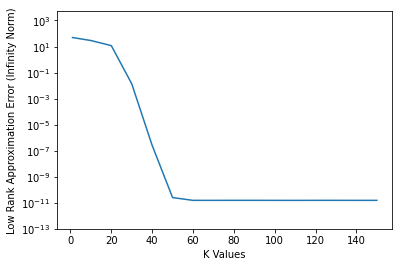

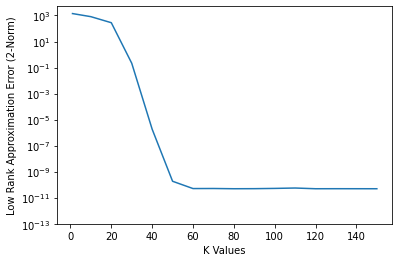

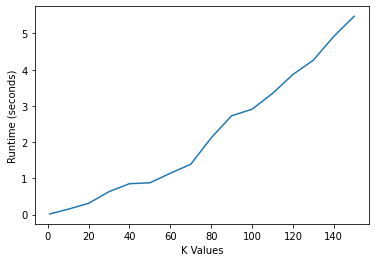

In [23]:
fig1 = plt.figure()
plt.plot(k_vals, errors_inf)
plt.xlabel('K Values')
plt.ylabel('Low Rank Approximation Error (Infinity Norm)')
plt.yscale('log')
plt.ylim([1e-13, 5000])
plt.show()

fig2 = plt.figure()
plt.plot(k_vals, errors_2norm)
plt.xlabel('K Values')
plt.ylabel('Low Rank Approximation Error (2-Norm)')
plt.yscale('log')
plt.ylim([1e-13, 5000])
plt.show()

fig3 = plt.figure()
plt.plot(k_vals, times)
plt.xlabel('K Values')
plt.ylabel('Runtime (seconds)')
plt.show()

In [189]:
tpca = time.time()
pca = PCA(n_components=3, svd_solver='arpack')
pca.fit(X)
X2 = pca.transform(X)
elapsed_pca = time.time() - tpca

k = 50
appx = 3
t3d2 = time.time()
T, V = lanczos(X, k)
U, D, Vt = approx_svd(T, V, m, appx)
proj_X = U[:,0:appx]*D[0:appx]
elapsed_t3d2 = time.time() - t3d2

print('Scikit-Learn Runtime:')
print(elapsed_pca)
print('Lanczos Approximation Method Runtime:')
print(elapsed_t3d2)

print(np.linalg.norm(abs(proj_X) - abs(X2)))
print(np.linalg.norm(abs(proj_X) - abs(Ux[:,0:appx]*Sx[0:appx])))
print(np.linalg.norm(abs(X2) - abs(Ux[:,0:appx]*Sx[0:appx])))


Scikit-Learn Runtime:
0.833470344543457
Lanczos Approximation Method Runtime:
0.9517145156860352
3.1458460720137e-11
5.972514679975384e-11
5.021271823183423e-11


In [131]:
num = 5000
mean = [0, 0, 0]
cov = [[20, 0, 0], [0, 100, 0], [0, 0, 50]] 
X_mvg = np.random.multivariate_normal(mean, cov, num)
noise = np.random.rand(num,20)
X_mvg_noise = np.hstack((X_mvg,noise))

In [132]:
df = pd.DataFrame(X_mvg, columns=["x", "y", "z"])
fig = px.scatter_3d(df, x = "x", y = "y", z = "z")
fig.update_traces(mode='markers', marker_size=2.5)
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[-30,30],),
                     yaxis = dict(nticks=4, range=[-30,30],),
                     zaxis = dict(nticks=4, range=[-30,30],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

fig.show()

In [133]:
Ug,Dg,Vg = np.linalg.svd(X_mvg_noise)
X_reconstruct = X_mvg_noise@Vg[:,0:3]
df = pd.DataFrame(X_reconstruct, columns=["x", "y", "z"])

In [134]:
k = 10
appx = 3
Tmvg, Vmvg = lanczos(X_mvg_noise, k)
Umvg, Dmvg, Vmvg = approx_svd(Tmvg, Vmvg, X_mvg_noise.shape[0], appx)
X_lanczos_rec = Umvg[:, 0:appx]*Dmvg[0:appx]
df = pd.DataFrame(X_lanczos_rec, columns=["x", "y", "z"])

In [135]:
fig = px.scatter_3d(df, x = "x", y = "y", z = "z")
fig.update_traces(mode='markers', marker_size=2.5)
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[-30,30],),
                     yaxis = dict(nticks=4, range=[-30,30],),
                     zaxis = dict(nticks=4, range=[-30,30],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))
fig.show()

In [191]:
num = 15000
A = np.random.rand(num,1000)

A = StandardScaler().fit_transform(A)

U,D2,Vh = np.linalg.svd(A)

In [203]:
tt = time.time()
T, V = lanczos(A, 290)
Yl, D, Yr = approx_svd(T, V, num, 3)
projA = Yl*D[0:3]
time1 = time.time() - tt

ttt = time.time()
pca = PCA(n_components=3, svd_solver='arpack')
pca.fit(A)
A2 = pca.transform(A)
time2 = time.time() - ttt


print(time1)
print(time2)
print(np.linalg.norm(abs(U[:,0:3]*D2[0:3]) - abs(projA)))
print(np.linalg.norm(abs(U[:,0:3]*D2[0:3]) - abs(A2)))


a=U[:,0:3]*D2[0:3]

print(A2[0,0])
print(a[0,0])
#a = A@Yr
#print(A@Yr)
#print(U[:,0:2]*D2[0:2])

#print('============')
#print(Yr[0:10,:])
#print('============')
#print(Vh.T[0:10,0:2])

#print('============')
#print(Yl[0:10,:])
#print('============')
#print(U[0:10,0:2])

16.890368461608887
4.57746696472168
1.4471471349834148e-10
4.528675854453747e-11
-0.06349014111537725
-0.06349014111537231
